In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score

In [2]:
# === 1. Load and Scale Data ===
df = pd.read_csv("Blocks_with_feature.csv")
features = ['blocks_per_pool_last_10', 'blocks_per_pool_per_day',
            'is_consecutive_block', 'is_unique_miner_last_10']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
# === 2. One-Class SVM Outlier Detection ===
svm = OneClassSVM(kernel='rbf', nu=0.2, gamma='scale')
df['os_outlier'] = svm.fit_predict(X_scaled)
df['os_outlier'] = df['os_outlier'].map({1: 0, -1: 1})

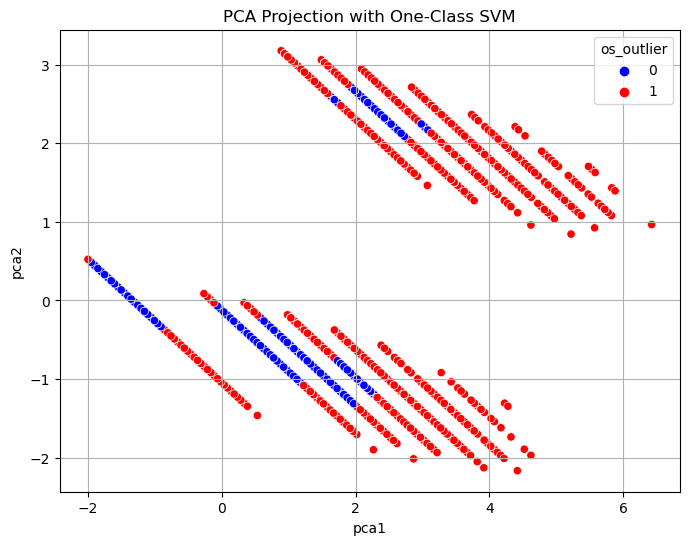

In [35]:
# === 3. PCA Visualization ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['pca1'], df['pca2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='os_outlier', palette={0: 'blue', 1: 'red'})
plt.title("PCA Projection with One-Class SVM")
plt.grid(True)
plt.show()

In [44]:
# === 4. Clustering on Outliers ===
df_outliers = df[df['os_outlier'] == 1].copy()
X_outliers = scaler.transform(df_outliers[features])

best_k, best_score = 2, -1
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=30, n_init='auto').fit(X_outliers)
    score = silhouette_score(X_outliers, kmeans.labels_)
    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters=best_k, random_state=30, n_init='auto')
df_outliers['cluster'] = kmeans.fit_predict(X_outliers)

print(f" Optimal clusters for outliers: {best_k} (Silhouette Score = {best_score:.3f})")

 Optimal clusters for outliers: 9 (Silhouette Score = 0.654)


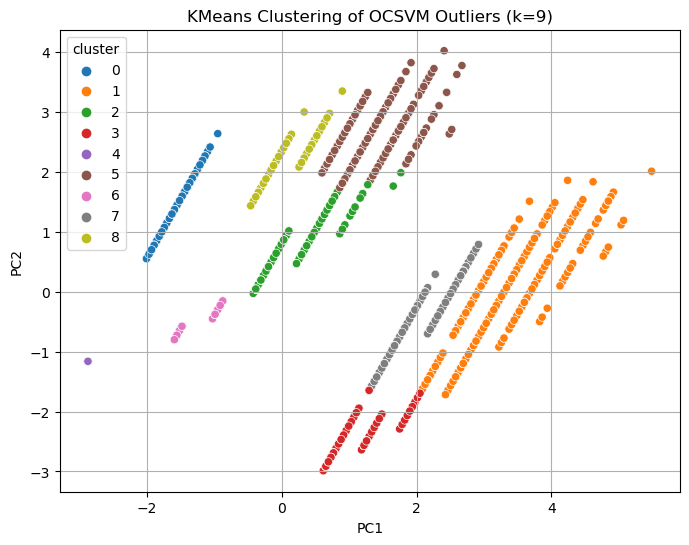

In [45]:
# === 5. Visualize Clusters ===
pca_outliers = PCA(n_components=2).fit_transform(X_outliers)
df_outliers['PC1'], df_outliers['PC2'] = pca_outliers[:, 0], pca_outliers[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_outliers, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title(f"KMeans Clustering of OCSVM Outliers (k={best_k})")
plt.grid(True)
plt.show()

In [46]:
# === 6. Label Low Activity Cluster ===
centers = kmeans.cluster_centers_
low_cluster_id = np.argmin([center[1] for center in centers])  # index 1 = blocks_per_pool_per_day
df_outliers['low_activity'] = (df_outliers['cluster'] == low_cluster_id).astype(int)

In [47]:
# === 7. Merge Labels Back ===
df['low_activity'] = 0
df.loc[df_outliers.index, 'low_activity'] = df_outliers['low_activity']

dangerous_clusters = [i for i in range(best_k) if i != low_cluster_id]
df_outliers['final_label'] = df_outliers['cluster'].apply(lambda x: 1 if x in dangerous_clusters else 0)

df['final_label'] = 0
df.loc[df_outliers.index, 'final_label'] = df_outliers['final_label']

In [48]:
# === 9. Train Decision Tree (Modified Depth) ===
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n--- Test Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


--- Test Set Evaluation ---
Accuracy: 0.9266046844269623
Confusion Matrix:
 [[8787  105]
 [ 716 1578]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96      8892
           1       0.94      0.69      0.79      2294

    accuracy                           0.93     11186
   macro avg       0.93      0.84      0.87     11186
weighted avg       0.93      0.93      0.92     11186



In [49]:
# === 8. Train-Test Split ===
df.loc[df['is_consecutive_block'] >= 0.5, 'final_label'] = 1
X_final = df[features]
y_final = df['final_label']
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, stratify=y_final, random_state=42)

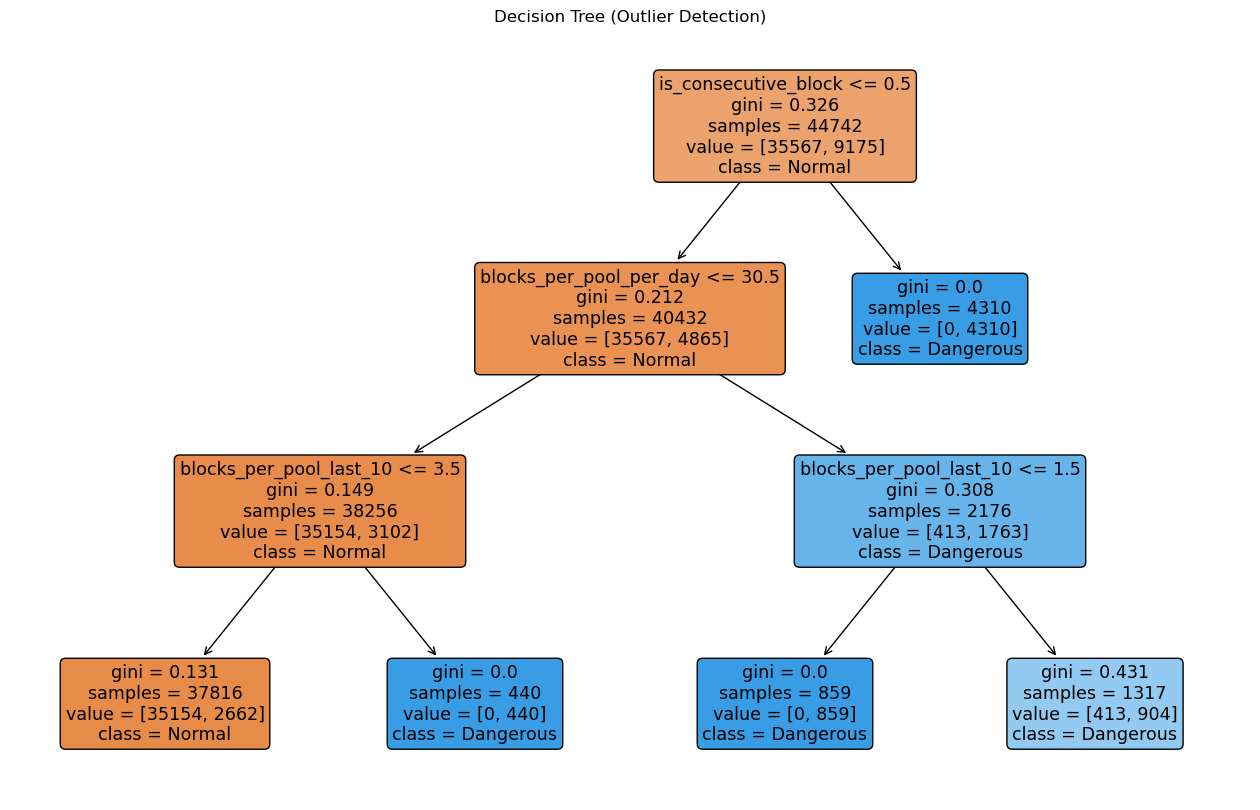

In [50]:
# === 10. Visualize Tree ===
plt.figure(figsize=(16, 10))
plot_tree(clf, feature_names=features, class_names=['Normal', 'Dangerous'], filled=True, rounded=True)
plt.title("Decision Tree (Outlier Detection)")
plt.show()

In [51]:
# === 11. Print Rules ===
print("\n--- Decision Tree Rules ---")
print(export_text(clf, feature_names=features))


--- Decision Tree Rules ---
|--- is_consecutive_block <= 0.50
|   |--- blocks_per_pool_per_day <= 30.50
|   |   |--- blocks_per_pool_last_10 <= 3.50
|   |   |   |--- class: 0
|   |   |--- blocks_per_pool_last_10 >  3.50
|   |   |   |--- class: 1
|   |--- blocks_per_pool_per_day >  30.50
|   |   |--- blocks_per_pool_last_10 <= 1.50
|   |   |   |--- class: 1
|   |   |--- blocks_per_pool_last_10 >  1.50
|   |   |   |--- class: 1
|--- is_consecutive_block >  0.50
|   |--- class: 1

